# Simulons le jeu de *151* avec Python !

## But :
- Simuler numériquement le jeu de 151, qui est une variante à 3 dés du jeu appelé [5000](https://fr.wikipedia.org/wiki/5000),
- Afin de trouver une stratégie *optimale*.

## Comment ?
- On va simuler des millions de parties (cf. [méthodes de Monte-Carlo](https://fr.wikipedia.org/wiki/Méthodes_de_Monte-Carlo)),
- Afin de comparer différentes stratégies (aléatoires, s'arrêter au premier coup, s'arrêter après 3 coups, etc),
- On les compare en fonction de leur gain *moyen*,
- La meilleur stratégie sera celle qui apporte un gain moyen le plus élevé.

## Résultats ?
→ Lien vers les résultats obtenus.

----

## Plans
1. fonctions pour simuler un tirage (3 dés),
2. puis simuler une une partie (affrontant deux stratégies, face à un total), plein de parties (total aléatoire),
3. implémenter différentes stratégies,
4. les comparer, faire des graphiques, et tirer des conclusions statistiquement valides (avec moyennes *et* écart-types).

----

## 1. Simuler un tirage et une partie

### 1.1. Simuler un tirage

Dépendances :

In [1]:
import numpy as np
import numpy.random as rn
rn.seed(0)  # Pour obtenir les mêmes résultats
import matplotlib.pyplot as plt

import seaborn as sns
sns.set(context="notebook", style="darkgrid", palette="hls", font="sans-serif", font_scale=1.4)

Première fonction : pour tirer trois dés, à 6 faces, indépendants.

In [2]:
def tirage(nb=1):
    """ Renvoie un numpy array de taille (3,) si nb == 1, sinon (nb, 3)."""
    if nb == 1:
        return rn.randint(1, 7, 3)
    else:
        return rn.randint(1, 7, (nb, 3))

Testons là :

In [3]:
tirage()

array([5, 6, 1])

In [4]:
tirage(10)

array([[4, 4, 4],
       [2, 4, 6],
       [3, 5, 1],
       [1, 5, 3],
       [2, 1, 2],
       [6, 2, 6],
       [1, 2, 5],
       [4, 1, 4],
       [6, 1, 3],
       [4, 1, 2]])

### 1.2. Points d'un tirage
Le jeu de *151* associe les points suivants, multiples de 50, aux tirages de 3 dés :

- 200 pour un brelan de 2, 300 pour un brelan de 3, .., 600 pour un brelan de 6, 700 pour un brelan de 1,
- 100 pour chaque 1, si ce n'est pas un brelan,
- 50 pour chaque 5, si ce n'est pas un brelan.

In [5]:
COMPTE_SUITE = False  # Savoir si on implémente aussi la variante avec les suites

def _points(valeurs, compte_suite=COMPTE_SUITE):
    if valeurs[0] == valeurs[1] == valeurs[2]:  # Un brelan !
        if valeurs[0] == 1:
            return 700
        else:
            return 100 * valeurs[0]
    else:            # Pas de brelan
        # Code pour compter les suites :
        bonus_suite = compte_suite and set(np.diff(np.sort(valeurs))) == {1}
        return 100 * (np.sum(valeurs == 1) + bonus_suite) + 50 * np.sum(valeurs == 5)


def points(valeurs, compte_suite=COMPTE_SUITE):
    """ Calcule les points du tirage correspondant à valeurs.
    
    - si valeurs est de taille (3,), renvoie un seul entier,
    - si valeurs est de taille (nb, 3), renvoie un tableau de points.
    """
    if len(np.shape(valeurs)) > 1:
        return np.array([_points(valeurs[i,:], compte_suite) for i in range(np.shape(valeurs)[0])])
    else:
        return _points(valeurs, compte_suite)

#### 1.2.1. Un seul tirage

Testons ces fonctions :

In [6]:
valeurs = tirage()
print("La valeur {} donne {:>5} points.".format(valeurs, points(valeurs)))

La valeur [4 6 4] donne     0 points.


In [7]:
for _ in range(20):
    valeurs = tirage()
    print("- La valeur {} donne {:>5} points.".format(valeurs, points(valeurs)))

- La valeur [4 1 2] donne   100 points.
- La valeur [2 2 1] donne   100 points.
- La valeur [3 5 4] donne    50 points.
- La valeur [4 3 5] donne    50 points.
- La valeur [3 1 1] donne   200 points.
- La valeur [5 6 6] donne    50 points.
- La valeur [1 5 2] donne   150 points.
- La valeur [5 2 3] donne    50 points.
- La valeur [3 1 2] donne   100 points.
- La valeur [2 2 2] donne   200 points.
- La valeur [4 4 3] donne     0 points.
- La valeur [4 1 4] donne   100 points.
- La valeur [6 5 2] donne    50 points.
- La valeur [3 5 4] donne    50 points.
- La valeur [5 5 5] donne   500 points.
- La valeur [4 5 5] donne   100 points.
- La valeur [5 1 5] donne   200 points.
- La valeur [4 3 6] donne     0 points.
- La valeur [6 6 1] donne   100 points.
- La valeur [2 6 2] donne     0 points.


Testons quelques valeurs particulières :

- Les brelans :

In [8]:
for valeur in range(1, 7):
    valeurs = valeur * np.ones(3, dtype=int)
    print("- La valeur {} donne {:>5} points.".format(valeurs, points(valeurs)))

- La valeur [1 1 1] donne   700 points.
- La valeur [2 2 2] donne   200 points.
- La valeur [3 3 3] donne   300 points.
- La valeur [4 4 4] donne   400 points.
- La valeur [5 5 5] donne   500 points.
- La valeur [6 6 6] donne   600 points.


- Les 1 :

In [9]:
for valeurs in [np.array([2, 3, 6]), np.array([1, 3, 6]), np.array([1, 1, 6])]:
    print("- La valeur {} donne {:>5} points.".format(valeurs, points(valeurs)))

- La valeur [2 3 6] donne     0 points.
- La valeur [1 3 6] donne   100 points.
- La valeur [1 1 6] donne   200 points.


- Les 5 :

In [10]:
for valeurs in [np.array([2, 3, 6]), np.array([5, 3, 6]), np.array([5, 5, 6])]:
    print("- La valeur {} donne {:>5} points.".format(valeurs, points(valeurs)))

- La valeur [2 3 6] donne     0 points.
- La valeur [5 3 6] donne    50 points.
- La valeur [5 5 6] donne   100 points.


→ C'est bon, *tout* marche !

*Note* : certaines variants du 151 accordent une valeur supplémentaire aux *suites* (non ordonnées) : [1, 2, 3] vaut 200, [2, 3, 4] vaut 100, et [3, 4, 5] et [4, 5, 6] vaut 150.
Ce n'est pas difficile à intégrer dans notre fonction `points`.

- Testons quand même les suites :

In [11]:
for valeurs in [np.array([1, 2, 3]), np.array([2, 3, 4]), np.array([3, 4, 5]), np.array([4, 5, 6])]:
    print("- La valeur {} donne {:>5} points.".format(valeurs, points(valeurs)))

- La valeur [1 2 3] donne   100 points.
- La valeur [2 3 4] donne     0 points.
- La valeur [3 4 5] donne    50 points.
- La valeur [4 5 6] donne    50 points.


#### 1.2.2. Plusieurs tirages

Testons ces fonctions :

In [12]:
valeurs = tirage(10)
print(valeurs)
print(points(valeurs))

[[4 1 6]
 [1 2 3]
 [5 3 1]
 [6 4 3]
 [3 6 1]
 [6 2 1]
 [3 3 4]
 [3 4 3]
 [2 3 4]
 [4 4 3]]
[100 100 150   0 100 100   0   0   0   0]


----

#### 1.2.3. Moyenne d'un tirage, et quelques figures

On peut faire quelques tests statistiques dès maintenant :

- Points moyens d'un tirage :

In [13]:
def moyenneTirage(nb=1000):
    return np.mean(points(tirage(nb), False))

def moyenneTirage_avecSuite(nb=1000):
    return np.mean(points(tirage(nb), True))

for p in range(2, 7):
    nb = 10 ** p
    print("- Pour {:>7} tirages, les tirages valent en moyenne {:>4} points.".format(nb, moyenneTirage(nb)))
    print("- Pour {:>7} tirages, les tirages valent en moyenne {:>4} points si on compte aussi les suites.".format(nb, moyenneTirage_avecSuite(nb)))

- Pour     100 tirages, les tirages valent en moyenne 95.0 points.
- Pour     100 tirages, les tirages valent en moyenne 100.0 points si on compte aussi les suites.
- Pour    1000 tirages, les tirages valent en moyenne 81.2 points.
- Pour    1000 tirages, les tirages valent en moyenne 98.0 points si on compte aussi les suites.
- Pour   10000 tirages, les tirages valent en moyenne 85.05 points.
- Pour   10000 tirages, les tirages valent en moyenne 97.3 points si on compte aussi les suites.
- Pour  100000 tirages, les tirages valent en moyenne 85.817 points.
- Pour  100000 tirages, les tirages valent en moyenne 96.6435 points si on compte aussi les suites.
- Pour 1000000 tirages, les tirages valent en moyenne 85.32135 points.
- Pour 1000000 tirages, les tirages valent en moyenne 96.55695 points si on compte aussi les suites.


Ça semble converger vers 85 : en moyenne, un tirage vaut entre 50 et 100 points, plutôt du côté des 100.
Et si on compte les suites, la valeur moyenne d'un tirage vaut plutôt 96 points (ça augmente comme prévu, mais ça augmente peu).

- Moyenne et écart type :

In [14]:
def moyenneStdTirage(nb=1000):
    pts = points(tirage(nb))
    return np.mean(pts), np.std(pts)

for p in range(2, 7):
    nb = 10 ** p
    m, s = moyenneStdTirage(nb)
    print("- Pour {:>7} tirages, les tirages valent en moyenne {:6.2f} +- {:>6.2f} points.".format(nb, m, s))

- Pour     100 tirages, les tirages valent en moyenne  79.00 +-  83.12 points.
- Pour    1000 tirages, les tirages valent en moyenne  88.15 +-  92.42 points.
- Pour   10000 tirages, les tirages valent en moyenne  86.97 +-  95.47 points.
- Pour  100000 tirages, les tirages valent en moyenne  85.26 +-  92.53 points.
- Pour 1000000 tirages, les tirages valent en moyenne  85.31 +-  92.73 points.


- Quelques courbes :

In [15]:
def plotPoints(nb=2000):
    pts = np.sort(points(tirage(nb)))
    m = np.mean(pts)
    plt.figure()
    plt.plot(pts, 'ro')
    plt.title("Valeurs de {} tirages. Moyenne = {:.2f}".format(nb, m))
    plt.show()

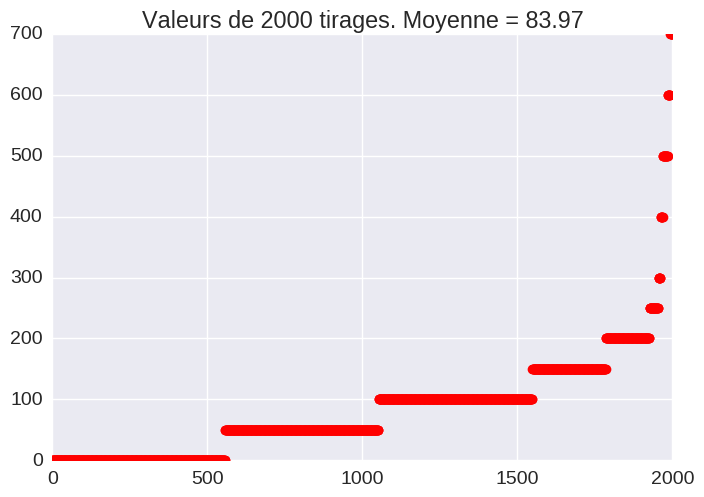

In [16]:
plotPoints()

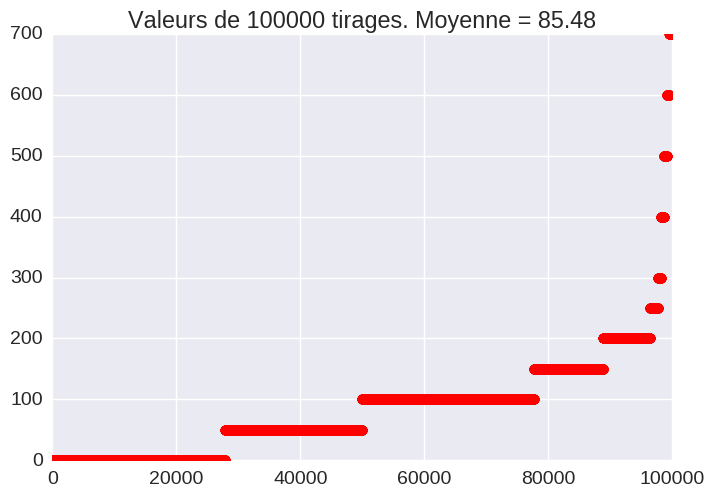

In [17]:
plotPoints(10**5)

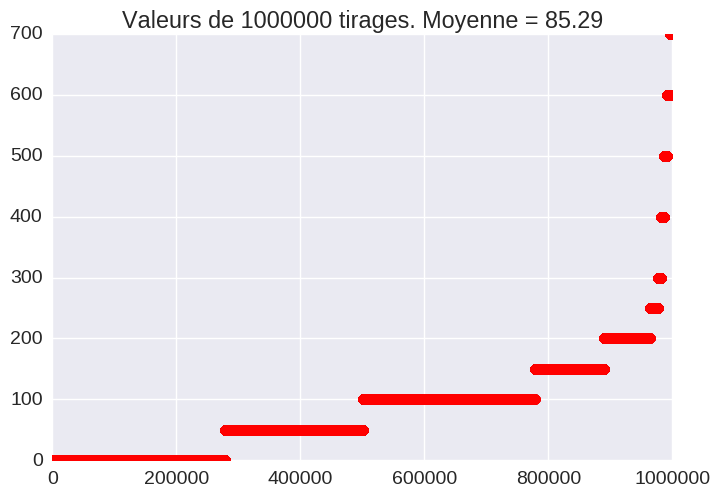

In [18]:
plotPoints(10**6)

- On peut calculer la probabilité d'avoir un tirage valant 0 points :

In [19]:
def probaPoints(nb=1000, pt=0, compte_suite=COMPTE_SUITE):
    pts = points(tirage(nb), compte_suite)
    return np.sum(pts == pt) / float(nb)

In [20]:
for p in range(2, 7):
    nb = 10 ** p
    prob = probaPoints(nb, compte_suite=False)
    print("- Pour {:>7} tirages, il y a une probabilité {:7.2%} d'avoir 0 point.".format(nb, prob))
    prob = probaPoints(nb, compte_suite=True)
    print("- Pour {:>7} tirages, il y a une probabilité {:7.2%} d'avoir 0 point si on compte les suites.".format(nb, prob))

- Pour     100 tirages, il y a une probabilité  16.00% d'avoir 0 point.
- Pour     100 tirages, il y a une probabilité  28.00% d'avoir 0 point si on compte les suites.
- Pour    1000 tirages, il y a une probabilité  27.00% d'avoir 0 point.
- Pour    1000 tirages, il y a une probabilité  26.70% d'avoir 0 point si on compte les suites.
- Pour   10000 tirages, il y a une probabilité  27.73% d'avoir 0 point.
- Pour   10000 tirages, il y a une probabilité  24.11% d'avoir 0 point si on compte les suites.
- Pour  100000 tirages, il y a une probabilité  27.90% d'avoir 0 point.
- Pour  100000 tirages, il y a une probabilité  24.97% d'avoir 0 point si on compte les suites.
- Pour 1000000 tirages, il y a une probabilité  27.81% d'avoir 0 point.
- Pour 1000000 tirages, il y a une probabilité  25.00% d'avoir 0 point si on compte les suites.


Donc un tirage apporte 85 points en moyenne, mais il y a environ 28% de chance qu'un tirage rate.

Si on compte les suites, un tirage apporte 97 points en moyenne, mais il y a environ 25% de chance qu'un tirage rate.

- On peut faire le même genre de calcul pour les différentes valeurs de points possibles :

In [21]:
# valeursPossibles = list(set(points(tirage(10000))))
valeursPossibles = [0, 50, 100, 150, 200, 250, 300, 400, 500, 600, 700]

In [22]:
for p in range(4, 7):
    nb = 10 ** p
    tirages = tirage(nb)
    pts   = points(tirages, False)
    pts_s = points(tirages, True)
    print("\n- Pour {:>7} tirages :".format(nb))
    for pt in valeursPossibles:
        prob = np.sum(pts   == pt) / float(nb)
        print("  - Il y a une probabilité {:7.2%} d'avoir {:3} point{}.".format(prob, pt, 's' if pt > 0 else ''))
        prob = np.sum(pts_s == pt) / float(nb)
        print("  - Il y a une probabilité {:7.2%} d'avoir {:3} point{} si on compte les suites.".format(prob, pt, 's' if pt > 0 else ''))


- Pour   10000 tirages :
  - Il y a une probabilité  28.33% d'avoir   0 point.
  - Il y a une probabilité  25.58% d'avoir   0 point si on compte les suites.
  - Il y a une probabilité  22.47% d'avoir  50 points.
  - Il y a une probabilité  16.68% d'avoir  50 points si on compte les suites.
  - Il y a une probabilité  27.77% d'avoir 100 points.
  - Il y a une probabilité  27.98% d'avoir 100 points si on compte les suites.
  - Il y a une probabilité  10.70% d'avoir 150 points.
  - Il y a une probabilité  16.49% d'avoir 150 points si on compte les suites.
  - Il y a une probabilité   7.28% d'avoir 200 points.
  - Il y a une probabilité   9.82% d'avoir 200 points si on compte les suites.
  - Il y a une probabilité   1.19% d'avoir 250 points.
  - Il y a une probabilité   1.19% d'avoir 250 points si on compte les suites.
  - Il y a une probabilité   0.42% d'avoir 300 points.
  - Il y a une probabilité   0.42% d'avoir 300 points si on compte les suites.
  - Il y a une probabilité   0.50% d'a

On devrait faire des histogrammes, mais j'ai la flemme...

Ces quelques expériences montrent qu'on a :
- une chance d'environ 2.5% d'avoir plus de 300 points (par un brelan),
- une chance d'environ 9%   d'avoir entre 200 et 300 points,
- une chance d'environ 11%  d'avoir 150 points,
- une chance d'environ 27%  d'avoir 100 points,
- une chance d'environ 22%  d'avoir 50  points,
- une chance d'environ 28%  d'avoir 0   point.

Autant de chance d'avoir 100 points que 0 ? Et oui !

La variante comptant les suites augmente la chance d'avoir 200 points (de 7.5% à 10%), d'avoir 150 points (de 11% à 16%), et diminue la chance d'avoir 0 point, mais ne change pas vraiment le reste du jeu.

----

### 1.3. Simuler des parties
#### 1.3.1. Simuler une partie
On va d'abord écrire une fonction qui prend deux joeurs, un total, et simule la partie, puis donne l'indice (0 ou 1) du joueur qui gagne.

In [23]:
DEBUG = False  # Par défaut, on n'affiche rien

In [24]:
def unJeu(joueur, compte, total, debug=DEBUG):
    accu = 0
    if debug: print("  - Le joueur {.__name__} commence à jouer, son compte est {} et le total est {} ...".format(joueur, compte, total))
    t = tirage()
    nbLance = 1
    if points(t) == 0:
        if debug: print("    - Hoho, ce tirage {} vallait 0 points, le joueur doit arrêter.".format(t))
        return 0, nbLance
    if debug: print("    - Le joueur a obtenu {} ...".format(t))
    while compte + accu <= total and joueur(compte, accu, t, total):
        accu += points(t)
        t = tirage()
        nbLance += 1
        if debug: print("    - Le joueur a décidé de rejouer, accumulant {} points, et a ré-obtenu {} ...".format(accu, t))
        if points(t) == 0:
            if debug: print("    - Hoho, ce tirage {} vallait 0 points, le joueur doit arrêter.".format(t))
            break
    accu += points(t)
    if compte + accu > total:
        if debug: print("  - Le joueur a dépassé le total : impossible de marquer ! compte = {} + accu = {} > total = {} !".format(compte, accu, total))
        return 0, nbLance
    else:
        if accu > 0:
            if debug: print("  - Le joueur peut marquer les {} points accumulés en {} lancés !".format(accu, nbLance))
        return accu, nbLance


def unePartie(joueurs, total=1000, debug=DEBUG, i0=0):
    assert len(joueurs) == 2, "Erreur, seulement 2 joueurs sont acceptés !"
    comptes  = [0, 0]
    nbCoups  = [0, 0]
    nbLances = [0, 0]
    scores   = [[0], [0]]
    if debug: print("- Le joueur #{} va commencer ...".format(i0))
    i = i0
    while max(comptes) != total:  # Tant qu'aucun joueur n'a gagné
        nbCoups[i] += 1
        if debug: print("- C'est au joueur #{} ({.__name__}) de jouer, son compte est {} et le total est {} ...".format(i, joueurs[i], comptes[i], total))
        accu, nbLance = unJeu(joueurs[i], comptes[i], total, debug)
        nbLances[i] += nbLance
        if accu > 0:
            comptes[i] += accu
            scores[i].append(comptes[i])  # Historique
        if comptes[i] == total:
            if debug: print("- Le joueur #{} ({.__name__}) a gagné en {} coups et {} lancés de dés !".format(i, joueurs[i], nbCoups[i], nbLances[i]))
            if debug: print("- Le joueur #{} ({.__name__}) a perdu, avec un score de {}, après {} coups et {} lancés de dés !".format(i^1, joueurs[i^1], comptes[i^1], nbCoups[i^1], nbLances[i^1]))
            return i, scores
        i ^= 1  # 0 → 1, 1 → 0 (ou exclusif)

# Note : on pourrait implémenter une partie à plus de 2 joueurs

----
#### 1.3.2. Des stratégies

On doit définir des stratégies, sous la forme de fonctions `joueur(compte, accu, t, total)`, qui renvoie `True` si elle doit continuer à jouer, ou `False` si elle doit marquer.

D'abord, deux stratégies un peu stupides :

In [25]:
def unCoup(compte, accu, t, total):
    """ Stratégie qui marque toujours au premier coup, peu importe le 1er tirage obtenu."""
    return False  # Marque toujours !

def jusquauBout(compte, accu, t, total):
    """ Stratégie qui ne marque que si elle peut gagner exactement ."""
    if compte + accu + points(t) >= total:
        return False  # Marque si elle peut gagner
    else:
        return True   # Continue à jouer

Une autre stratégie, qui marche seulement si elle peut marquer plus de X points (100, 150 etc).
C'est la version plus "gourmande" de `unCoup`, qui marque si elle a plus de 50 points.

In [26]:
def auMoinsX(X):
    def joueur(compte, accu, t, total):
        """ Stratégie qui marque si elle a eu plus de {} points.""".format(X)
        if accu + points(t) >= X:
            return False  # Marque si elle a obtenu plus de X points
        elif compte + accu + points(t) == total:
            return False  # Marque si elle peut gagner
        elif total - compte < X:
            # S'il reste peu de points, marque toujours
            # (sinon la stratégie d'accumuler plus de X points ne marche plus)
            return False
        else:
            return True   # Continue de jouer, essaie d'obtenir X points
    joueur.__name__ = "auMoins{}".format(X)  # Triche sur le nom
    return joueur

auMoins50  = auMoinsX(50)    # == unCoup, en fait
auMoins100 = auMoinsX(100)
auMoins150 = auMoinsX(150)
auMoins200 = auMoinsX(200)   # Commence à devenir très audacieux
auMoins250 = auMoinsX(250)
auMoins300 = auMoinsX(300)   # Compètement fou, très peu de chance de marquer ça
auMoins350 = auMoinsX(350)
auMoins400 = auMoinsX(400)
auMoins450 = auMoinsX(450)
auMoins500 = auMoinsX(500)
auMoins550 = auMoinsX(550)
auMoins600 = auMoinsX(600)
auMoins650 = auMoinsX(650)
auMoins700 = auMoinsX(700)
# On pourrait continuer ...
auMoins800 = auMoinsX(800)
auMoins850 = auMoinsX(850)
auMoins900 = auMoinsX(900)
auMoins950 = auMoinsX(950)
auMoins1000 = auMoinsX(1000)

Une autre stratégie "stupide" : décider aléatoirement, selon une loi de Bernoulli, si elle continue ou si elle s'arrête.

In [27]:
def bernoulli(p=0.5):
    def joueur(compte, accu, t, total):
        """ Marque les points accumulés avec probabilité p = {} (Bernoulli).""".format(p)
        return rn.random() > p
    joueur.__name__ = "bernoulli_{:.3g}".format(p)
    return joueur

----
#### 1.3.3. Quelques exemples
Essayons de faire joueur deux stratégies face à l'autre.

In [28]:
joueurs = [unCoup, unCoup]
total = 200

unePartie(joueurs, total, True)
unePartie(joueurs, total)

- Le joueur #0 va commencer ...
- C'est au joueur #0 (unCoup) de jouer, son compte est 0 et le total est 200 ...
  - Le joueur unCoup commence à jouer, son compte est 0 et le total est 200 ...
    - Le joueur a obtenu [4 5 4] ...
  - Le joueur peut marquer les 50 points accumulés en 1 lancés !
- C'est au joueur #1 (unCoup) de jouer, son compte est 0 et le total est 200 ...
  - Le joueur unCoup commence à jouer, son compte est 0 et le total est 200 ...
    - Le joueur a obtenu [6 1 2] ...
  - Le joueur peut marquer les 100 points accumulés en 1 lancés !
- C'est au joueur #0 (unCoup) de jouer, son compte est 50 et le total est 200 ...
  - Le joueur unCoup commence à jouer, son compte est 50 et le total est 200 ...
    - Hoho, ce tirage [6 4 6] vallait 0 points, le joueur doit arrêter.
- C'est au joueur #1 (unCoup) de jouer, son compte est 100 et le total est 200 ...
  - Le joueur unCoup commence à jouer, son compte est 100 et le total est 200 ...
    - Le joueur a obtenu [3 5 6] ...
  - 

(0, [[0, 200], [0]])

In [29]:
joueurs = [unCoup, jusquauBout]
total = 200
unePartie(joueurs, total)

(1, [[0, 50], [0, 100, 200]])

In [30]:
joueurs = [unCoup, auMoins100]
total = 500
unePartie(joueurs, total)

(1, [[0, 100, 200, 350, 400], [0, 100, 200, 350, 450, 500]])

In [31]:
joueurs = [unCoup, auMoins200]
total = 1000
unePartie(joueurs, total)

(0,
 [[0, 100, 150, 250, 400, 600, 700, 750, 900, 1000],
  [0, 200, 300, 550, 750, 900, 950]])

----

#### 1.3.4. Générer plusieurs parties
On peut maintenant lancer plusieurs centaines de simulations de parties, sans afficher le déroulement de chaque parties.
La fonction `unePartie` renvoie un tuple, `(i, comptes)`, où :
- `i` est l'indice (0 ou 1) du joueur ayant gagné la partie,
- et `comptes` est une liste contenant les deux historiques des points des deux joueurs.

Par exemple, pour un `total = 500`, la sortie `(1, [[0, 100, 150, 250, 450], [0, 50, 450, 500]])` signifie :
- le joueur 1 a gagné, après avoir marqué 50 points, puis 400, et enfin 50,
- le joueur 2 a perdu, après avoir marqué 100 points, puis 50, puis 100, puis 200, mais a perdu avec 450 points.

In [32]:
def desPartie(nb, joueurs, total=1000, i0=0):
    indices, historiques = [], []
    for _ in range(nb):
        i, h = unePartie(joueurs, total=total, i0=i0, debug=False)
        indices.append(i)
        historiques.append(h)
    return indices, historiques

Par exemple, on peut opposer le joueur pas courageux (`unCoup`) au joueur très gourmand (`jusquauBout`) sur 100 parties avec un total de 250 points :

In [33]:
def freqGain(indiceMoyen, i):
    # (1^i) + ((-1)**(i==0)) * indiceMoyen
    if i == 0:
        return 1 - indiceMoyen
    else:
        return indiceMoyen

In [34]:
def afficheResultatsDesParties(nb, joueurs, total, indices, historiques):
    indiceMoyen = np.mean(indices)
    pointsFinaux = [np.mean(list(historiques[k][i][-1] for k in range(nb))) for i in [0, 1]]

    print("Dans {} parties simulées, contre le total {} :".format(nb, total))
    for i in [0, 1]:
        print(" - le joueur {} ({.__name__:<11}) a gagné {:>5.2%} du temps, et a eu un score final moyen de {:>5g} points ...".format(i, joueurs[i], freqGain(indiceMoyen, i), pointsFinaux[i]))


In [35]:
nb = 10000
joueurs = [unCoup, jusquauBout]
total = 1000
indices, historiques = desPartie(nb, joueurs, total)
afficheResultatsDesParties(nb, joueurs, total, indices, historiques)

Dans 10000 parties simulées, contre le total 1000 :
 - le joueur 0 (unCoup     ) a gagné 12.11% du temps, et a eu un score final moyen de 553.635 points ...
 - le joueur 1 (jusquauBout) a gagné 87.89% du temps, et a eu un score final moyen de 977.425 points ...


In [36]:
nb = 10000
joueurs = [unCoup, jusquauBout]
total = 500
indices, historiques = desPartie(nb, joueurs, total)
afficheResultatsDesParties(nb, joueurs, total, indices, historiques)

Dans 10000 parties simulées, contre le total 500 :
 - le joueur 0 (unCoup     ) a gagné 24.83% du temps, et a eu un score final moyen de 315.35 points ...
 - le joueur 1 (jusquauBout) a gagné 75.17% du temps, et a eu un score final moyen de 453.565 points ...


In [37]:
nb = 10000
joueurs = [unCoup, jusquauBout]
total = 5000
indices, historiques = desPartie(nb, joueurs, total)
afficheResultatsDesParties(nb, joueurs, total, indices, historiques)

Dans 10000 parties simulées, contre le total 5000 :
 - le joueur 0 (unCoup     ) a gagné 0.04% du temps, et a eu un score final moyen de 1751.06 points ...
 - le joueur 1 (jusquauBout) a gagné 99.96% du temps, et a eu un score final moyen de 4999.95 points ...


----
Affichons une première courbe qui montrera la supériorité d'une stratégie face à la plus peureuse, en fonction du total.

In [38]:
def plotResultatsDesParties(nb, joueurs, totaux):
    N = len(totaux)
    indicesMoyens = []
    for total in totaux:
        indices, _ = desPartie(nb, joueurs, total)
        indicesMoyens.append(np.mean(indices))
    plt.figure()
    plt.plot(totaux, indicesMoyens, 'ro')
    plt.xlabel("Objectif (points totaux à atteindre)")
    plt.ylabel("Taux de victoire de 1 face à 0")
    plt.title("Taux de victoire du joueur 1 ({.__name__}) face au joueur 0 ({.__name__}),\n pour {} parties simulees pour chaque total.".format(joueurs[1], joueurs[0], nb))
    plt.show()

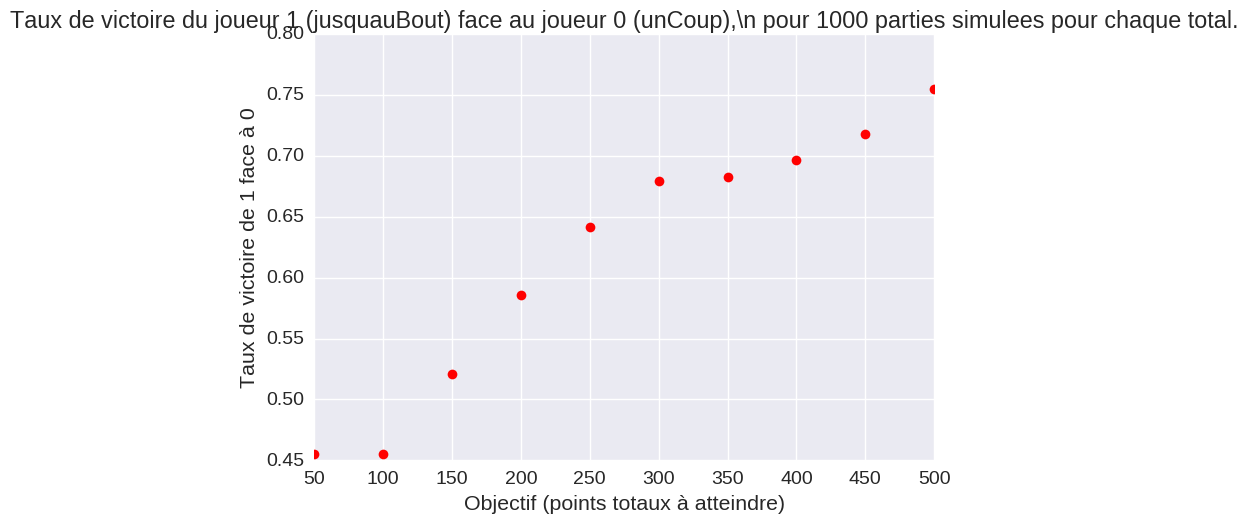

In [39]:
nb = 1000
joueurs = [unCoup, jusquauBout]
totaux = [50, 100, 150, 200, 250, 300, 350, 400, 450, 500]
plotResultatsDesParties(nb, joueurs, totaux)

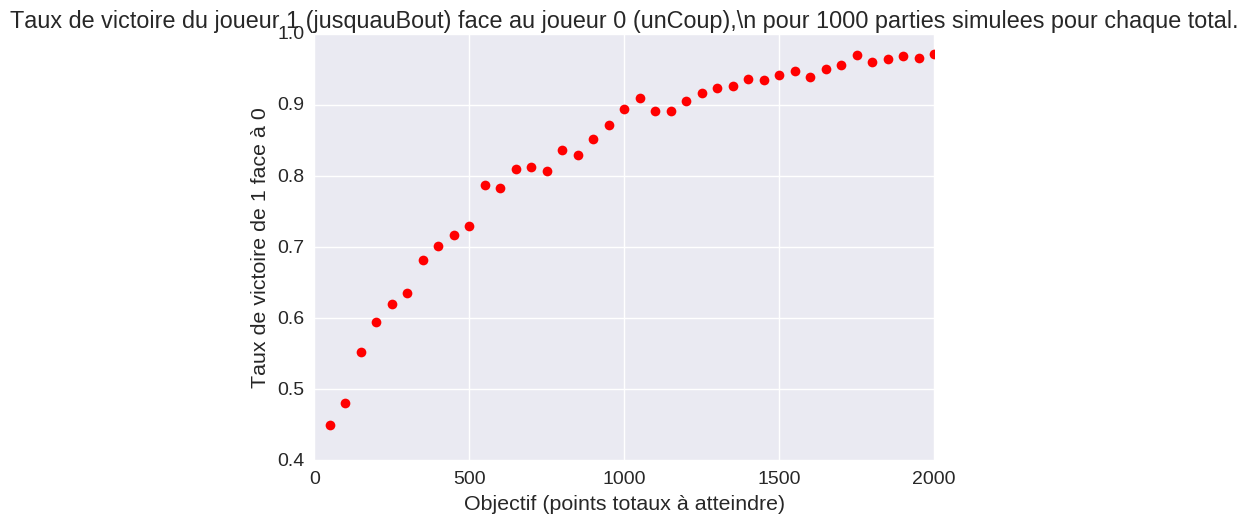

In [40]:
nb = 1000
joueurs = [unCoup, jusquauBout]
totalMax = 2000
totaux = list(range(50, totalMax + 50, 50))
plotResultatsDesParties(nb, joueurs, totaux)

----
D'autres comparaisons, entre stratégies gourmandes.

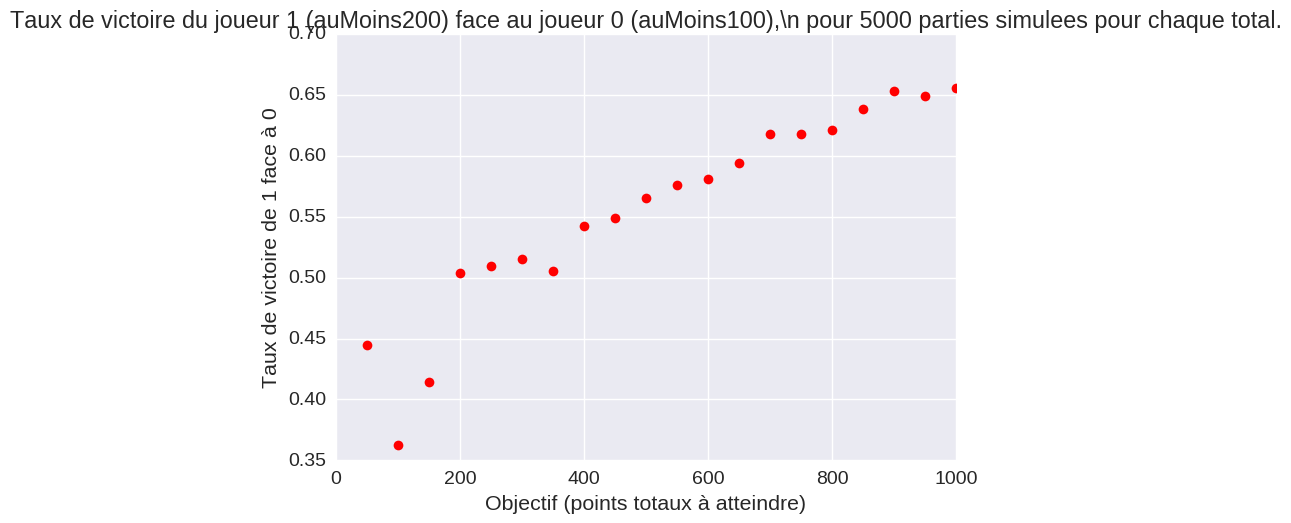

In [41]:
nb = 5000
joueurs = [auMoins100, auMoins200]
totalMax = 1000
totaux = list(range(50, totalMax + 50, 50))
plotResultatsDesParties(nb, joueurs, totaux)

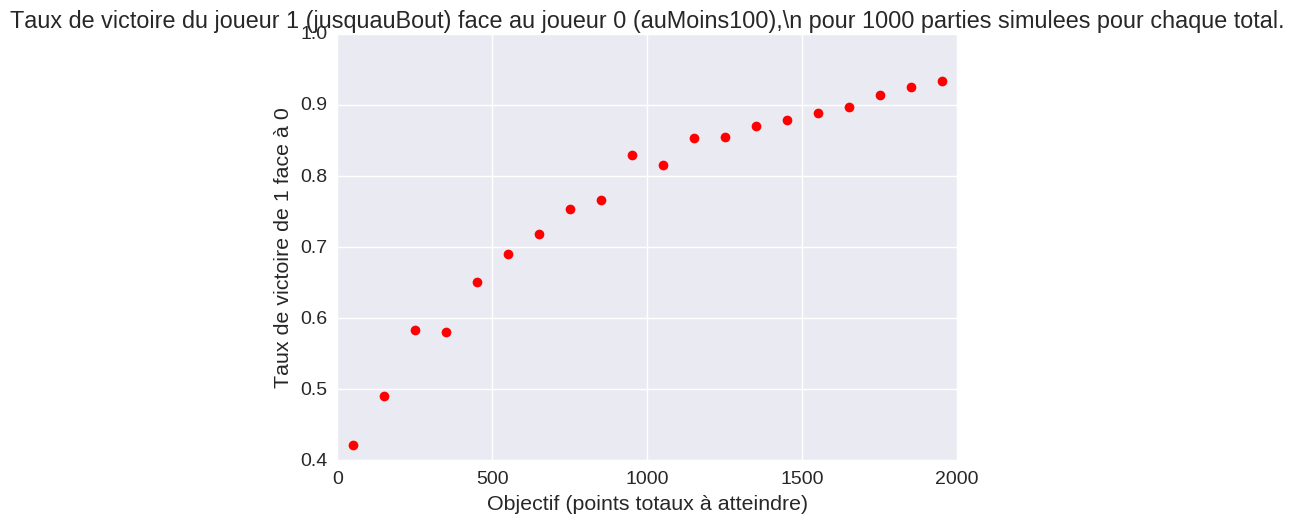

In [42]:
nb = 1000
joueurs = [auMoins100, jusquauBout]
totalMax = 2000
totaux = list(range(50, totalMax + 50, 100))
plotResultatsDesParties(nb, joueurs, totaux)

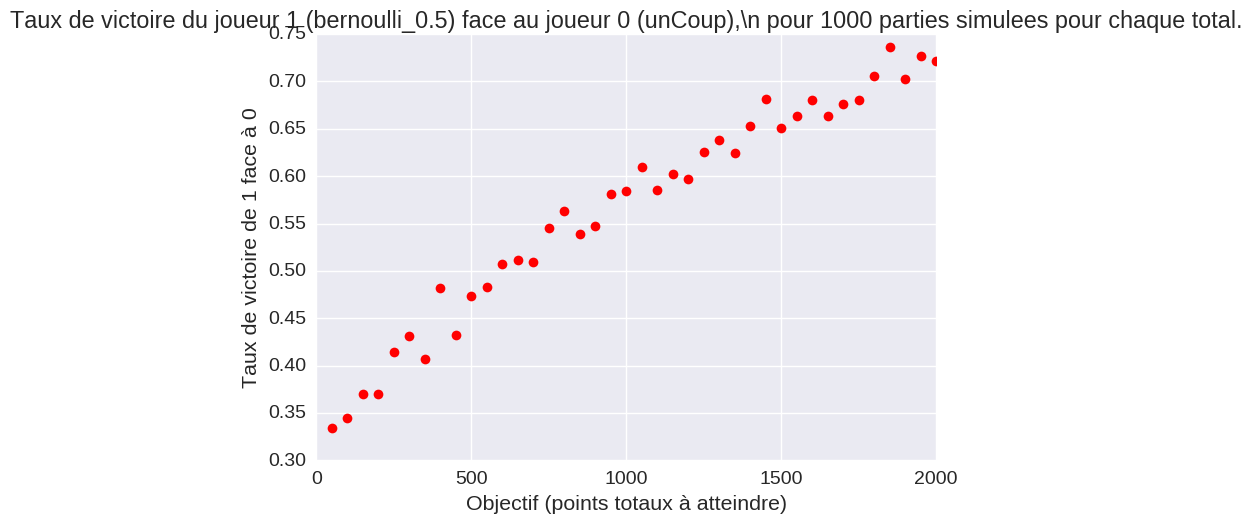

In [43]:
nb = 1000
totalMax = 2000
totaux = list(range(50, totalMax + 50, 50))

joueurs = [unCoup, bernoulli(0.5)]
plotResultatsDesParties(nb, joueurs, totaux)

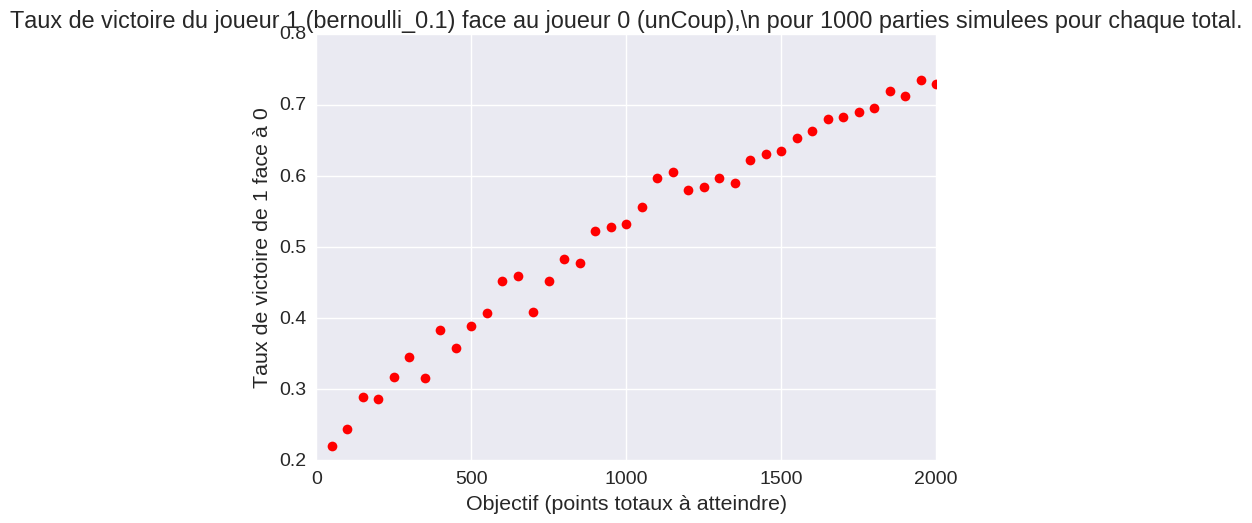

In [44]:
joueurs = [unCoup, bernoulli(0.1)]
plotResultatsDesParties(nb, joueurs, totaux)

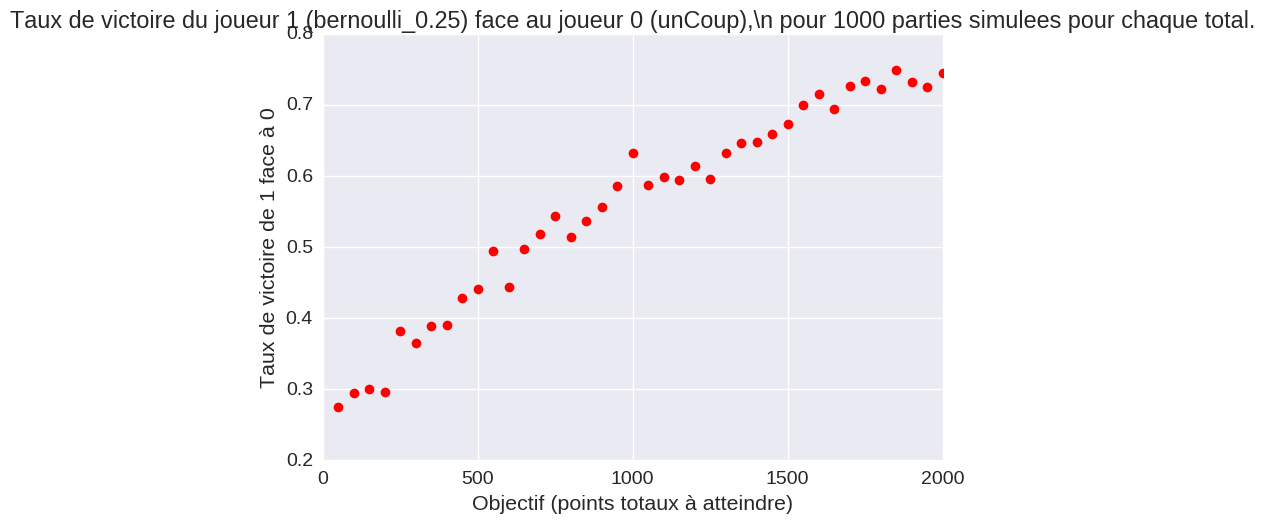

In [45]:
joueurs = [unCoup, bernoulli(0.25)]
plotResultatsDesParties(nb, joueurs, totaux)

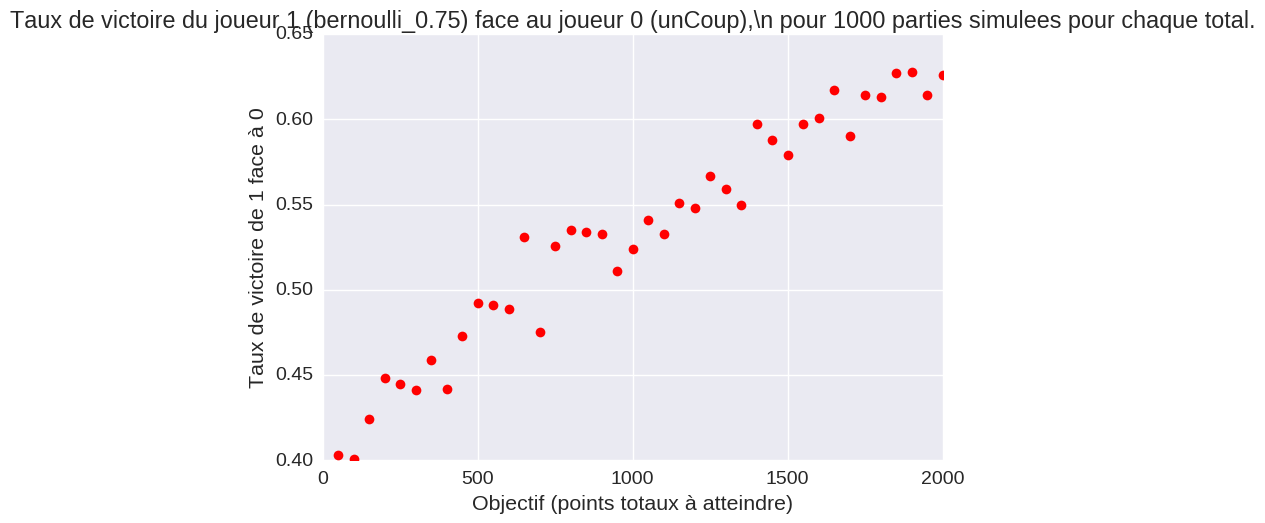

In [46]:
joueurs = [unCoup, bernoulli(0.75)]
plotResultatsDesParties(nb, joueurs, totaux)

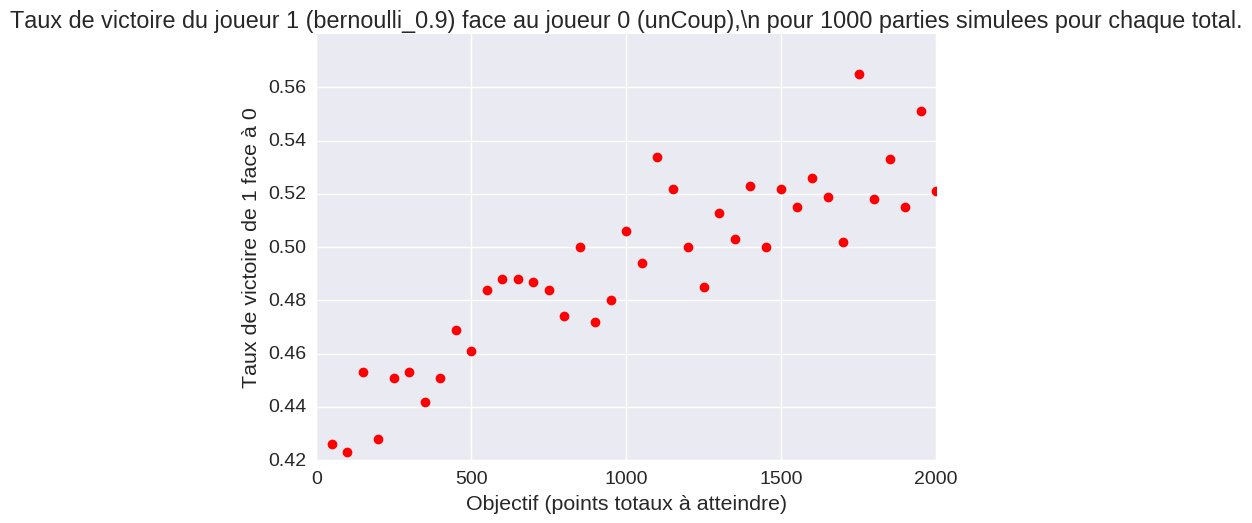

In [47]:
joueurs = [unCoup, bernoulli(0.9)]
plotResultatsDesParties(nb, joueurs, totaux)